# Example: Reconciling Expert Opinions

This tutorial demonstrates how time dependent expert opinions can be reconciled in a Bayesian framework. We make use of the following effect handlers in order to modify model behavior:
- [poutine.reparam](http://docs.pyro.ai/en/latest/poutine.html#pyro.poutine.handlers.reparam) for splitting observations to several random variables using the [SplitReparam](https://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.split.SplitReparam) reparameterizer.
- [poutine.condition](http://docs.pyro.ai/en/latest/poutine.html#pyro.poutine.handlers.condition) for assigning fixed values to random variables. 
- [poutine.equalize](http://docs.pyro.ai/en/latest/poutine.html#pyro.poutine.handlers.equalize) for forcing random variables to have the same values.

## Summary
- Effect handlers are useful in modifying model behavior, beyond the straightforward use of effect handlers in order to condition models on known observations. 
- Directly sampling from modified models is often not possible, and one should resort to inference methods such as SVI or MCMC in order to sample from models modified by effect handlers.
- The above is true even if the models are not conditioned on known observations.


## Some Preliminaries

We can view a time dependent expert opinion $x_i$ as a random walk process developing over time step $i$ such that

$$
x_{i+1} = x_i + \epsilon_i
$$
with the $x_i$ being the observations and the $\epsilon_i$ being the innovations.

We start with some imports and setup.

In [1]:
import torch, pyro, os

import pyro.distributions as dist
from pyro.nn import PyroModuleList, PyroModule, PyroSample
from pyro.infer.reparam import SplitReparam

from matplotlib import pyplot as plt

smoke_test = ('CI' in os.environ)  # for use in continuous integration testing
num_samples = 4 if smoke_test else 1000
num_svi_iter = 4 if smoke_test else 1001

Let's define an expert model as a class.

In [2]:
# Define the innovations to observations transform
class CumSumTransform(dist.transforms.Transform):
    domain = dist.constraints.independent(dist.constraints.real, 1)
    codomain = dist.constraints.independent(dist.constraints.real, 1)
    bijective = True

    def log_abs_det_jacobian(self, x, y):
        return x.new_zeros(x.shape[:(-1)])

    def _call(self, x):
        return x.cumsum(dim=-1)

    def _inverse(self, x):
        return torch.diff(x, prepend=x.new_zeros(x.shape[:-1] + (1,)))

# The expert class defines the actual distributions of the innovations and observations
class Expert(PyroModule):
    def __init__(self, num_steps, scale, loc=torch.tensor(0.0)):
        super().__init__()
        self.scale = scale
        self.loc = loc
        self.num_steps = num_steps
        self.obs = PyroSample(lambda self: dist.TransformedDistribution(self.innovations(), CumSumTransform()))

    def innovations(self):
        eps = dist.Normal(self.loc[..., None], self.scale[..., None])
        return eps.expand(eps.batch_shape[:-1] + (self.num_steps,)).to_event(1)

    def forward(self):
        return self.obs


We can combine several experts into a single model class, along with Bayesian priors for the scale of the innovations.

In [3]:
class Model(PyroModule):
    def __init__(self, num_experts, num_steps, scale_prior_dist=pyro.distributions.LogNormal(loc=0, scale=1)):
        super().__init__()
        self.experts = PyroModuleList([Expert(num_steps, PyroSample(scale_prior_dist)) for expert_num in range(num_experts)])
    
    def forward(self):
        return torch.cat([expert()[..., None] for expert in self.experts], dim=-1)



Now let's create a model with two experts and 50 time steps.

In [4]:
num_experts = 2
num_steps = 50

model = Model(num_experts, num_steps)

As the model is Bayesian it has priors for all of its parameters and we can sample from it right away, even without any conditioning on known observations.

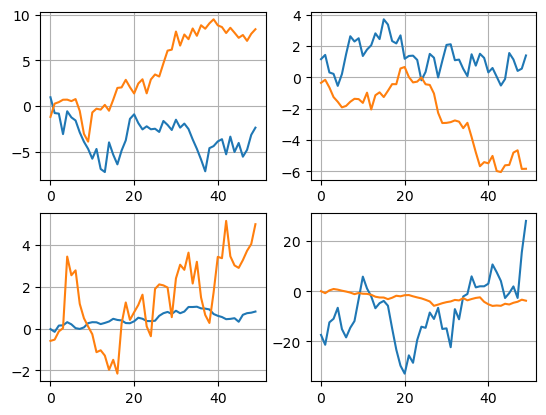

In [5]:
seed = 42
pyro.set_rng_seed(seed)
pyro.clear_param_store()

plt.figure()
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(model().detach().numpy())
    plt.grid()

The two time series are independent and have different step variance. The model can be described by the directed graph shown below, where each node represents a random variable and the edges represent the dependencies between the random variables

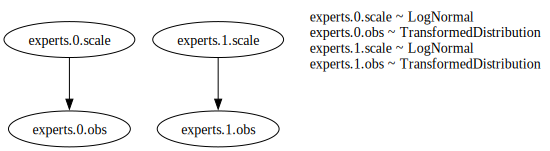

In [6]:
pyro.render_model(model, render_distributions=True)

The directed graph describes the model's probability function which assigns a probability to each outcome of the model.

$$
P_M \left( x_i^{(j)}, \epsilon_i^{(j)} \right)
$$

## Prior Knowledge and Model Conditioning

Model conditioning allows us to incorporate prior knowledge into the model, altering its predictions to reflect the effect of the prior knowledge.

We mark the conditionining of the model by

$$
P_M \left( x_i^{(j)}, \epsilon_i^{(j)} | \text{condition} \right) =
\frac{ P_M \left( x_i^{(j)}, \epsilon_i^{(j)}, \text{condition} \right) }{ P_M \left( \text{condition} \right) }
$$

which is usually difficult to calculate and sample from. Note that index $i$ marks the time step and index $j$ marks the time series (expert).

A very simple form of model conditioning can be setting the last observation of both time series to zero, as described in the conditioned model defined below.

In [7]:
# Split the last observation time step from previous time steps
reparams = dict()
for expert_num in range(num_experts):
    # The arguments to SplitReparam are, a list of section lengths,
    # and the dimension over which to split the random variable into those sections.
    reparams[f'experts.{expert_num}.obs'] = SplitReparam([num_steps - 1, 1], -1)
split_reparam_model = pyro.poutine.reparam(model, config=reparams)

# Set the last observation time step to zero
zero_ultimate_model = pyro.poutine.condition(split_reparam_model, data={f"experts.{n}.obs_split_1":
                                                                        torch.zeros(1)
                                                                        for n in range(num_experts)})

Now comes the tricky part, we need a way to sample from the conditioned model. The method we choose is called Stochastic Variational Inference (SVI) but other methods like Markov Chain Monte Carlo (MCMC) will also do. SVI creates a guide which approximates the distribution of samples from the conditioned model. 

In [8]:
def fit(model, *args, **kwargs):
    guide = pyro.infer.autoguide.guides.AutoMultivariateNormal(model)
    optimizer = pyro.optim.Adam(dict(lr=0.01))
    loss = pyro.infer.JitTrace_ELBO(num_particles=20, vectorize_particles=True, ignore_jit_warnings=True)
    svi = pyro.infer.SVI(model, guide, optimizer, loss)
    for count in range(num_svi_iter):
        loss = svi.step(*args, **kwargs)
        if count % 100 == 0:
            print(f"iteration {count} loss = {loss}")
    return guide

pyro.set_rng_seed(seed)
pyro.clear_param_store()

guide = fit(zero_ultimate_model)

iteration 0 loss = 189.6769256591797
iteration 100 loss = 37.504974365234375
iteration 200 loss = 20.005374908447266
iteration 300 loss = 18.326749801635742
iteration 400 loss = 16.923477172851562
iteration 500 loss = 16.572237014770508
iteration 600 loss = 16.390729904174805
iteration 700 loss = 14.698869705200195
iteration 800 loss = 15.261019706726074
iteration 900 loss = 14.944127082824707
iteration 1000 loss = 14.985832214355469


We now sample from the conditioned model and guide, in order to show how the conditioned model behaves.

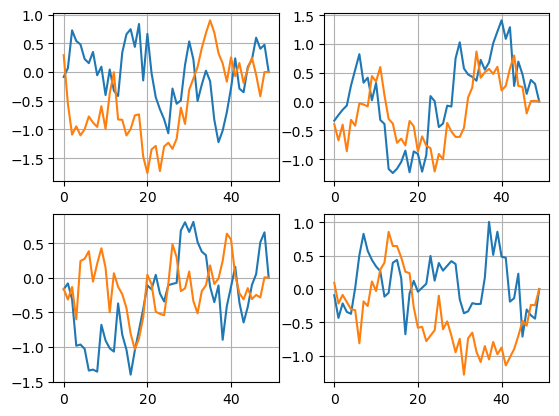

In [9]:
sampler = pyro.infer.Predictive(zero_ultimate_model, guide=guide,
                                num_samples=num_samples, parallel=True, return_sites=('_RETURN',))
samples = sampler()['_RETURN']

plt.figure()
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(samples[i].detach().numpy())
    plt.grid()

A more interesting conditioned model is one where both time series must converge to the same value, but not necessarily zero. This is how a panel of experts would behave, where ongoing predictions of an ultimate value, by all experts, must eventually converge to the same value.

The model that describes such a condition is described below.

In [10]:
same_ultimate_model = pyro.poutine.equalize(split_reparam_model, r"experts\.[0-9]+\.obs_split_1", keep_dist=True)

Sampling from this model requires creating a new guide.

In [11]:
pyro.set_rng_seed(seed)
pyro.clear_param_store()

guide = fit(same_ultimate_model)

iteration 0 loss = 187.51556396484375
iteration 100 loss = 36.83899688720703
iteration 200 loss = 19.414623260498047
iteration 300 loss = 16.364402770996094
iteration 400 loss = 15.203102111816406
iteration 500 loss = 15.109318733215332
iteration 600 loss = 15.28489875793457
iteration 700 loss = 14.779726028442383
iteration 800 loss = 15.220026016235352
iteration 900 loss = 13.708727836608887
iteration 1000 loss = 14.914263725280762


Equipeed with the new guide we can now sample from the same ultimate value model.

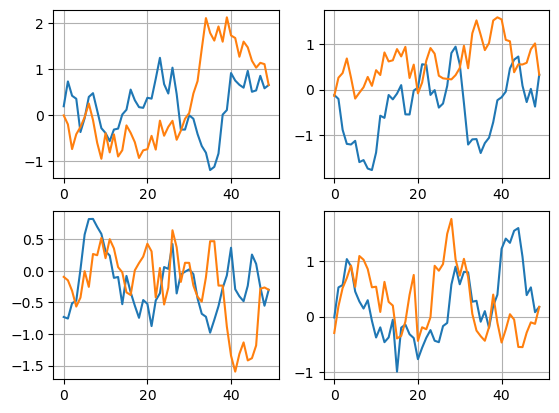

In [12]:
sampler = pyro.infer.Predictive(same_ultimate_model, guide=guide,
                                num_samples=num_samples, parallel=True, return_sites=('_RETURN',))
samples = sampler()['_RETURN']

plt.figure()
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(samples[i].detach().numpy())
    plt.grid()

The model exhibits the correct behavior with ultimate values of both time series converging to the same value.

## Adding Observations

Lastly, we would like to be able to take into account actual observations when working with the same ultimate model. This  completes the Bayesian framework which incorporates our:
- Model.
- Prior knowledge.
- Observations.

In order to do that we need to modify the same ultimate model so that we can observe some of the first samples.

In [13]:
num_observed = int(num_steps / 2)

# Split the observations into three parts where the first part will be conditioned by our observations
reparams = dict()
for expert_num in range(num_experts):
    reparams[f'experts.{expert_num}.obs'] = SplitReparam([num_observed, num_steps - num_observed - 1, 1], -1)
split_reparam_model = pyro.poutine.reparam(model, config=reparams)

# Ensure experts agree on last observation
same_ultimate_model = pyro.poutine.equalize(split_reparam_model, r"experts\.[0-9]+\.obs_split_2", keep_dist=True)

# Condition by our observations
observations = samples[0][..., range(num_observed), :]
conditioned_same_ultimate_model = pyro.poutine.condition(same_ultimate_model, data={f"experts.{n}.obs_split_0":
                                                                                    observations[..., n]
                                                                                    for n in range(num_experts)})

We now fit the model to the first half of the samples generated in the first sub-plot of the previous graph, by creating a new guide that enables sampling from the model combining both prior knowledge and actual observations.

In [14]:
pyro.set_rng_seed(seed)
pyro.clear_param_store()

guide = fit(conditioned_same_ultimate_model)

iteration 0 loss = 147.98159790039062
iteration 100 loss = 40.59894561767578
iteration 200 loss = 28.505329132080078
iteration 300 loss = 26.82405662536621
iteration 400 loss = 27.98712730407715
iteration 500 loss = 27.576807022094727
iteration 600 loss = 27.878671646118164
iteration 700 loss = 27.198638916015625
iteration 800 loss = 26.90561294555664
iteration 900 loss = 27.4914493560791
iteration 1000 loss = 26.847055435180664


We now sample from the newly created guide.

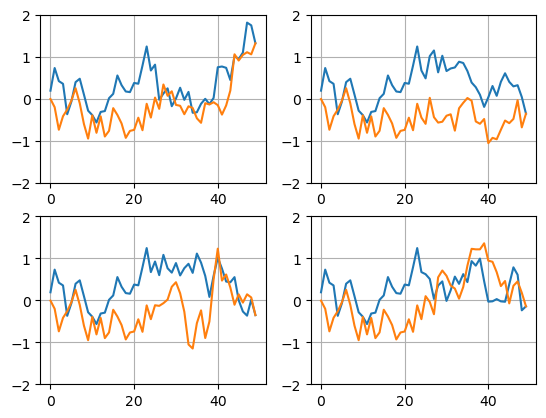

In [15]:
new_sampler = pyro.infer.Predictive(conditioned_same_ultimate_model, guide=guide,
                                    num_samples=num_samples, parallel=True, return_sites=('_RETURN',))
new_samples = new_sampler()['_RETURN']

plt.figure()
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(new_samples[i].detach().numpy())
    plt.ylim([-2, 2])
    plt.grid()

We can see that all samples are comprised of the same first half of observed samples, while still maintaining the same end value for both time series (our prior knowledge).

Overlayling many samples over each other we see that both time series (experts) tend towards each other in order to ensure agreement is achieved at the last samples.

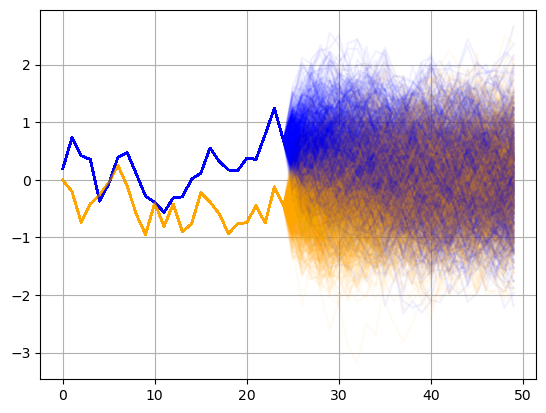

In [16]:
plt.figure()
for i in range(new_samples.shape[0]):
    plt.plot(new_samples[i, ..., 0].detach().numpy(), alpha=0.05, color='blue')
    plt.plot(new_samples[i, ..., 1].detach().numpy(), alpha=0.05, color='orange')
plt.grid()